## Import necessary libraries

In [12]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!pip install lxml

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


## Part 1 - Create DataFrames with neighborhoods, postal codes and coordinates for NYC, Toronto, and Paris 

### NYC (Manhattan)

In [13]:
# download data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# fill the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# define only Manhattan data
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

# get coordinates of Manhattan
address = 'Manhattan, NY'

#geolocator = Nominatim(user_agent="ny_explorer")
#location = geolocator.geocode(address)
ny_latitude = 40.78343
ny_longitude = -73.96625
print('The geograpical coordinate of Manhattan are {}, {}.'.format(ny_latitude, ny_longitude))

Data downloaded!
The geograpical coordinate of Manhattan are 40.78343, -73.96625.


### Toronto

In [14]:
#download data
toronto_data= pd.DataFrame(pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0])

#clean data
toronto_data.rename(columns={"Postcode": "PostalCode"},inplace= True)
g_toronto_data = toronto_data.groupby(['PostalCode'], as_index = False).agg({'Borough':'first','Neighborhood':', '.join})
g_toronto_data['Neighborhood'] = np.where(g_toronto_data['Neighborhood'] == 'Not assigned', g_toronto_data['Borough'],g_toronto_data['Neighborhood'])
g_toronto_data['Neighborhood'] = np.where(g_toronto_data['Neighborhood'] == 'Not assigned', g_toronto_data['Borough'],g_toronto_data['Neighborhood'])

# add coordinates to dataframe
toronto_lat_long = pd.read_csv('Geospatial_Coordinates.csv')
toronto_lat_long.rename(columns={'Postal Code':'PostalCode'}, inplace =True)
toronto_lat_long.set_index('PostalCode')
g_toronto_data.set_index('PostalCode')
toronto_complete_data = pd.merge(g_toronto_data,toronto_lat_long)

# get coordinates of Toronto
address = 'Toronto, ON'

#geolocator = Nominatim(user_agent="toronto_explorer")
#location = geolocator.geocode(address)
toronto_latitude = 43.651070
toronto_longitude = -79.347015
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinate of Toronto are 43.65107, -79.347015.


### Paris

In [15]:
#download data
paris_data= pd.DataFrame(pd.read_html('https://en.wikipedia.org/wiki/Arrondissements_of_Paris')[2])
paris_data = paris_data.iloc[:,0:2]
paris_data.rename(columns={"Arrondissement (R for Right Bank, L for Left Bank)": "Arrondissement","Name":"Neighborhood"},inplace= True)

# add coordinates to dataframe
paris_lat_long = pd.read_csv('Paris_Coordinates.csv')
paris_lat_long.set_index('Neighborhood')
paris_data.set_index('Neighborhood')
paris_complete_data = pd.merge(paris_data,paris_lat_long)
paris_complete_data.head()

# get coordinates of Paris
paris_latitude = 48.864716
paris_longitude = 2.349014
print('The geograpical coordinate of Paris are {}, {}.'.format(paris_latitude, paris_longitude))

The geograpical coordinate of Paris are 48.864716, 2.349014.


## Part 2 - Let's construct maps of NYC, Toronto and Paris

### NYC

In [16]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Toronto

In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_complete_data['Latitude'], toronto_complete_data['Longitude'], toronto_complete_data['Borough'], toronto_complete_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Paris

In [18]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(paris_complete_data['Latitude'], paris_complete_data['Longitude'], paris_complete_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## Part 3 - Let's segment the neighborhoods

### Define Foursquare credentials

In [19]:
CLIENT_ID = 'MM5FJRWZEO4IR3W4VWEKZZ1X5YKM5PZU2DQ0XVU3G5GKHHSL' # your Foursquare ID
CLIENT_SECRET = 'FBXGZEHH5DREP2YL400DMX0DCWG2OBLQG2CTBHPUI3O35EQK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MM5FJRWZEO4IR3W4VWEKZZ1X5YKM5PZU2DQ0XVU3G5GKHHSL
CLIENT_SECRET:FBXGZEHH5DREP2YL400DMX0DCWG2OBLQG2CTBHPUI3O35EQK


In [22]:
# Create a function to explore neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Explore Neighborhoods

#### NYC

In [23]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
There are 334 uniques categories.


#### Toronto

In [120]:
toronto_venues = getNearbyVenues(names=toronto_complete_data['Neighborhood'],
                                   latitudes=toronto_complete_data['Latitude'],
                                   longitudes=toronto_complete_data['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


#### Paris

In [121]:
paris_venues = getNearbyVenues(names=paris_complete_data['Neighborhood'],
                                   latitudes=paris_complete_data['Latitude'],
                                   longitudes=paris_complete_data['Longitude']
                                  )
print(paris_venues.shape)
paris_venues.head()

Louvre
Bourse
Temple
Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Butte-Montmartre
Buttes-Chaumont
Ménilmontant
(1519, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Louvre,48.855997,2.337999,Chez Nous,48.855823,2.340271,Wine Bar
1,Louvre,48.855997,2.337999,Prescription Cocktail Club,48.854921,2.337768,Cocktail Bar
2,Louvre,48.855997,2.337999,Hôtel d'Aubusson,48.854729,2.339505,Hotel
3,Louvre,48.855997,2.337999,L'Hotel,48.856377,2.335193,Hotel
4,Louvre,48.855997,2.337999,Monnaie de Paris,48.856833,2.339058,Museum


### Analyze each neighborhood

#### NYC

In [122]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

ny_neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Memorial Site,Wine Shop
1,Carnegie Hill,Coffee Shop,Pizza Place,Cosmetics Shop,Bakery,Wine Shop
2,Central Harlem,African Restaurant,Chinese Restaurant,French Restaurant,American Restaurant,Bar
3,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,American Restaurant
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Spa,Bakery


#### Toronto

In [125]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [126]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_onehot_grouped['Neighborhood']

for ind in np.arange(toronto_onehot_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_onehot_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Steakhouse,Café,Hotel
1,Agincourt,Breakfast Spot,Latin American Restaurant,Skating Rink,Clothing Store,Lounge
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Yoga Studio,Eastern European Restaurant,Discount Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fast Food Restaurant,Pizza Place,Sandwich Place,Beer Store
4,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Skating Rink,Coffee Shop


#### Paris

In [127]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

paris_onehot_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

In [128]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
paris_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
paris_neighborhoods_venues_sorted['Neighborhood'] = paris_onehot_grouped['Neighborhood']

for ind in np.arange(paris_onehot_grouped.shape[0]):
    paris_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_onehot_grouped.iloc[ind, :], num_top_venues)

paris_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Batignolles-Monceau,French Restaurant,Bar,Wine Bar,Hotel,Italian Restaurant
1,Bourse,French Restaurant,Japanese Restaurant,Hotel,Bistro,Italian Restaurant
2,Butte-Montmartre,Bar,French Restaurant,Pizza Place,Hotel,Deli / Bodega
3,Buttes-Chaumont,French Restaurant,Bar,Supermarket,Hotel,Lebanese Restaurant
4,Entrepôt,French Restaurant,Coffee Shop,Hotel,Bar,Pizza Place


### Find best k to use k-mean using the silhouette method

#### NYC

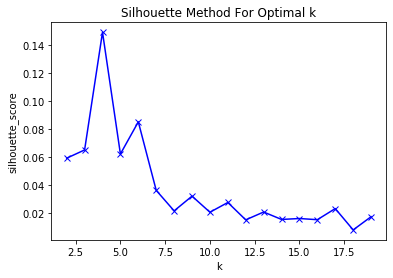

In [130]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

sil =[]
K_sil = range(2,20)

for k in K_sil:
    km = KMeans(n_clusters=k)
    km = km.fit(manhattan_grouped_clustering)
    labels = km.labels_
    sil.append(silhouette_score(manhattan_grouped_clustering, labels, metric='euclidean'))
    
# Plot
plt.plot(K_sil,sil , 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at 4, as such we will use k = 4 for Manhattan

#### Toronto

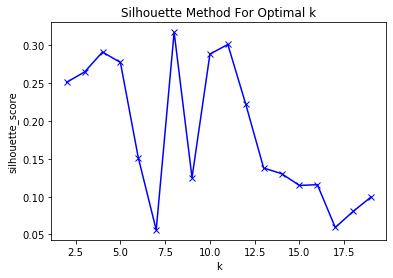

In [131]:
toronto_grouped_clustering = toronto_onehot_grouped.drop('Neighborhood', 1)

sil =[]
K_sil = range(2,20)

for k in K_sil:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    labels = km.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric='euclidean'))
    
# Plot
plt.plot(K_sil,sil , 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at 4, as such we will use k = 4 for Toronto

### Paris

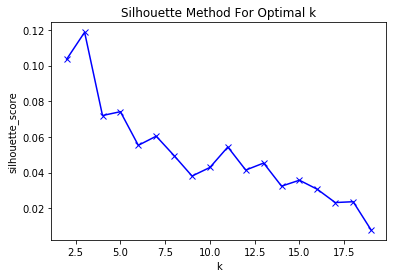

In [132]:
paris_grouped_clustering = paris_onehot_grouped.drop('Neighborhood', 1)

sil =[]
K_sil = range(2,20)

for k in K_sil:
    km = KMeans(n_clusters=k)
    km = km.fit(paris_grouped_clustering)
    labels = km.labels_
    sil.append(silhouette_score(paris_grouped_clustering, labels, metric='euclidean'))
    
# Plot
plt.plot(K_sil,sil , 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at 3, as such we will use k = 3 for Paris

### Cluster Neighborhoods

#### NYC

In [133]:
# set number of clusters
ny_kclusters = 4

# run k-means clustering
ny_kmeans = KMeans(n_clusters=ny_kclusters, random_state=0).fit(manhattan_grouped_clustering)

# add clustering labels
ny_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(ny_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Coffee Shop,Sandwich Place,Yoga Studio,Bank,Big Box Store
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Cocktail Bar,American Restaurant,Spa,Bakery
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Bakery,Grocery Store,Mobile Phone Shop,Chinese Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Pizza Place,Restaurant,Bakery,Café
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant


#### Toronto

In [134]:
# set number of clusters
toronto_kclusters = 4

# run k-means clustering
toronto_kmeans = KMeans(n_clusters=toronto_kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', toronto_kmeans.labels_)

toronto_merged = toronto_complete_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Bar,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Breakfast Spot,Intersection,Spa,Rental Car Location,Pizza Place
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Insurance Office,Korean Restaurant,Yoga Studio,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Bakery


#### Paris

In [135]:
# set number of clusters
paris_kclusters = 3

# run k-means clustering
paris_kmeans = KMeans(n_clusters=paris_kclusters, random_state=0).fit(paris_grouped_clustering)

# add clustering labels
paris_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', paris_kmeans.labels_)

paris_merged = paris_complete_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(paris_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')

paris_merged.head()

,Arrondissement,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1st (Ie) R,Louvre,75001,48.855997,2.337999,1,French Restaurant,Hotel,Italian Restaurant,Plaza,Café
1,2nd (IIe) R,Bourse,75002,48.868163,2.337665,1,French Restaurant,Japanese Restaurant,Hotel,Bistro,Italian Restaurant
2,3rd (IIIe) R,Temple,75003,48.864025,2.361470,1,Bistro,Café,Coffee Shop,Wine Bar,Hotel
3,4th (IVe) R,Hôtel-de-Ville,75004,48.856804,2.351056,1,French Restaurant,Ice Cream Shop,Plaza,Art Gallery,Cocktail Bar
4,5th (Ve) L,Panthéon,75005,48.846249,2.344604,1,French Restaurant,Hotel,Bar,Italian Restaurant,Café


### Explore Clusters

In [136]:
required_column = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']

#### NYC

In [137]:
nycluster_1= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for col in required_column:
    print(nycluster_1[col].value_counts(ascending=False))
    print('---------------------------------------------')

Italian Restaurant    3
Café                  1
Coffee Shop           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop           1
Clothing Store        1
Wine Bar              1
Park                  1
Italian Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Mexican Restaurant    2
Sushi Restaurant      1
Bar                   1
Café                  1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [138]:
nycluster_2= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for col in required_column:
    print(nycluster_2[col].value_counts(ascending=False))
    print('---------------------------------------------')

Italian Restaurant      6
Theater                 2
American Restaurant     2
Clothing Store          1
Coffee Shop             1
Gym / Fitness Center    1
Yoga Studio             1
Hotel                   1
Park                    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant         5
Café                       2
New American Restaurant    1
American Restaurant        1
Cocktail Bar               1
Boutique                   1
Theater                    1
Gym / Fitness Center       1
Coffee Shop                1
Hotel                      1
Exhibit                    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop               3
Art Gallery               2
Gym / Fitness Center      2
Pizza Place               2
Furniture / Home Store    1
Cosmetics Shop            1
Bakery                    1
Ice Cream Shop            1
Café                      1
Plaza              

In [139]:
nycluster_3= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for col in required_column:
    print(nycluster_3[col].value_counts(ascending=False))
    print('---------------------------------------------')

Mexican Restaurant    2
Café                  1
Pizza Place           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Bakery           2
Pizza Place      1
Deli / Bodega    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Latin American Restaurant    1
Café                         1
Restaurant                   1
Grocery Store                1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [140]:
nycluster_4= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for col in required_column:
    print(nycluster_4[col].value_counts(ascending=False))
    print('---------------------------------------------')

Park    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Bookstore    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------




#### Toronto

In [142]:
torontocluster_1= toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
for col in required_column:
    print(torontocluster_1[col].value_counts(ascending=False))
    print('---------------------------------------------')

Coffee Shop                 22
Café                         7
Fast Food Restaurant         5
Caribbean Restaurant         3
Breakfast Spot               3
Pharmacy                     3
Clothing Store               3
Indian Restaurant            2
Park                         2
Bus Line                     2
Pizza Place                  2
Grocery Store                2
Bar                          2
Airport Terminal             1
Portuguese Restaurant        1
American Restaurant          1
Bakery                       1
Sandwich Place               1
Playground                   1
Gift Shop                    1
Mediterranean Restaurant     1
Hakka Restaurant             1
Greek Restaurant             1
Hotel                        1
Empanada Restaurant          1
Discount Store               1
Rental Car Location          1
Light Rail Station           1
Japanese Restaurant          1
Gym                          1
College Stadium              1
Field                        1
Cafeteri

In [143]:
torontocluster_2= toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
for col in required_column:
    print(torontocluster_2[col].value_counts(ascending=False))
    print('---------------------------------------------')

Park                 13
Food & Drink Shop     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Playground                    3
Convenience Store             2
Women's Store                 1
Bus Line                      1
Airport                       1
Bank                          1
Grocery Store                 1
Park                          1
Construction & Landscaping    1
Jewelry Store                 1
Smoke Shop                    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio             4
Fast Food Restaurant    1
Electronics Store       1
Sushi Restaurant        1
Bank                    1
Basketball Court        1
Photography Studio      1
Tennis Court            1
Trail                   1
River                   1
Convenience Store       1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [144]:
torontocluster_3= toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
for col in required_column:
    print(torontocluster_3[col].value_counts(ascending=False))
    print('---------------------------------------------')

Baseball Field                1
Construction & Landscaping    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio       1
Baseball Field    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio          1
Electronics Store    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [145]:
torontocluster_4= toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
for col in required_column:
    print(torontocluster_4[col].value_counts(ascending=False))
    print('---------------------------------------------')

Garden    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Eastern European Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Discount Store    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


#### Paris

In [146]:
pariscluster_1= paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
for col in required_column:
    print(pariscluster_1[col].value_counts(ascending=False))
    print('---------------------------------------------')

French Restaurant    3
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Hotel     2
Bakery    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bistro    1
Café      1
Bar       1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [147]:
pariscluster_2= paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
for col in required_column:
    print(pariscluster_2[col].value_counts(ascending=False))
    print('---------------------------------------------')

French Restaurant    10
Bar                   3
Bistro                2
Hotel                 1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
French Restaurant      4
Hotel                  4
Bar                    2
Italian Restaurant     2
Japanese Restaurant    1
Café                   1
Ice Cream Shop         1
Coffee Shop            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Hotel                 4
Supermarket           2
Italian Restaurant    2
Pizza Place           1
Bistro                1
Café                  1
Wine Bar              1
Coffee Shop           1
Thai Restaurant       1
Bar                   1
Plaza                 1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


In [148]:
pariscluster_3= paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
for col in required_column:
    print(pariscluster_3[col].value_counts(ascending=False))
    print('---------------------------------------------')

Bakery    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
French Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Café    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------
